In [48]:
# Importing essential libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource

In [43]:
# Load datasets

orders = pd.read_csv('orders.csv')
order_products = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [44]:
# Merge datasets

merged_df = orders.merge(order_products, on='order_id').merge(products, on='product_id').merge(aisles, on='aisle_id').merge(departments, on='department_id')
merged_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks,beverages
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,soft drinks,beverages
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,soft drinks,beverages
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,soft drinks,beverages
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,2939884,130327,prior,3,1,13,0.0,27414,5,0,Organic Emmer Farro,68,10,bulk grains rice dried goods,bulk
32434485,3267360,150683,prior,1,5,16,NaN,27414,13,0,Organic Emmer Farro,68,10,bulk grains rice dried goods,bulk
32434486,414077,159238,prior,9,6,12,8.0,27414,1,0,Organic Emmer Farro,68,10,bulk grains rice dried goods,bulk
32434487,813243,171675,prior,13,2,6,13.0,27414,34,0,Organic Emmer Farro,68,10,bulk grains rice dried goods,bulk


In [51]:
# Feature Engineering

customer_features1 = merged_df.groupby('user_id').agg({
    'order_id': 'nunique',  # Order Frequency
    'product_id': 'count',  # Total products purchased
    'reordered': 'mean',    # Reorder ratio
    'aisle_id': 'nunique',  # Aisle diversity
}).rename(columns={
    'order_id': 'order_frequency',
    'product_id': 'total_products',
    'reordered': 'reorder_ratio',
    'aisle_id': 'aisle_diversity',
})

customer_features1

,order_frequency,total_products,reorder_ratio,aisle_diversity
user_id,,,,
1,10,59,0.694915,12
2,14,195,0.476923,33
3,12,88,0.625000,16
4,5,18,0.055556,14
5,4,37,0.378378,16
...,...,...,...,...
206205,3,32,0.250000,17
206206,67,285,0.473684,50
206207,16,223,0.587444,46


In [52]:
# Choose valuable features

customer_features2 = merged_df.groupby('user_id').agg({
    'days_since_prior_order': 'mean',  # Average days between orders
    'order_number': lambda x: np.mean(x.value_counts()),  # Average order size
    'product_id': 'nunique',  # Unique products ordered
}).rename(columns={
    'days_since_prior_order': 'avg_days_between_orders',
    'order_number': 'avg_order_size',
    'product_id': 'unique_products_ordered'
})

customer_features2

,avg_days_between_orders,avg_order_size,unique_products_ordered
user_id,,,
1,20.259259,5.900000,18
2,15.967033,13.928571,102
3,11.487179,7.333333,33
4,15.357143,3.600000,17
5,14.500000,9.250000,23
...,...,...,...
206205,20.666667,10.666667,24
206206,4.042705,4.253731,150
206207,14.879397,13.937500,92


In [53]:
# Joined the two dataframes
customer_features_combined = customer_features1.join(customer_features2)

# Displaying the resulting dataframe
customer_features_combined

,order_frequency,total_products,reorder_ratio,aisle_diversity,avg_days_between_orders,avg_order_size,unique_products_ordered
user_id,,,,,,,
1,10,59,0.694915,12,20.259259,5.900000,18
2,14,195,0.476923,33,15.967033,13.928571,102
3,12,88,0.625000,16,11.487179,7.333333,33
4,5,18,0.055556,14,15.357143,3.600000,17
5,4,37,0.378378,16,14.500000,9.250000,23
...,...,...,...,...,...,...,...
206205,3,32,0.250000,17,20.666667,10.666667,24
206206,67,285,0.473684,50,4.042705,4.253731,150
206207,16,223,0.587444,46,14.879397,13.937500,92


In [54]:
# Initialize Bokeh
output_notebook()

# Define a function to create histograms
def create_histogram(data, column_name, bins=30):
    hist, edges = np.histogram(data, bins=bins)
    p = figure(title=f"Histogram of {column_name}", 
               background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], 
           fill_color="navy", line_color="white", alpha=0.5)
    return p

# List of columns to plot
columns = customer_features_combined.columns

# Create a list of plots
plots = [create_histogram(customer_features_combined[col], col) for col in columns]

# Arrange plots in a grid
grid = gridplot([plots[i:i+3] for i in range(0, len(plots), 3)], sizing_mode='scale_both')

# Show the plots
show(grid)

Loading BokehJS ...

In [55]:
# Defined function to standarize(normalise) the data

def standard_scaler(data):
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    scaled_data = (data - mean) / std_dev
    return scaled_data, mean, std_dev

customer_features_scaled, mean, std_dev = standard_scaler(customer_features_combined.values)

print('Scaled_customer_features:', customer_features_scaled, sep = '\n')
#print('\nmean:',mean, end='\n')
#print('\nstandard deviation:',std_dev)

Scaled_customer_features:
[[-0.33566236 -0.48132062  1.23815226 ...  0.66453607 -0.69097766
  -0.82230831]
 [-0.0954904   0.18466785  0.21058293 ...  0.06900713  0.67825489
   0.66199514]
 [-0.21557638 -0.33930838  0.90858644 ... -0.55255432 -0.44652986
  -0.55725412]
 ...
 [ 0.02459559  0.32178313  0.73155509 ... -0.08189794  0.67977761
   0.48529235]
 [ 2.00601431  2.54500936  1.29763077 ... -1.11379192  0.65911209
   2.35834195]
 [-0.15553339 -0.13853244  0.19146918 ...  0.66683964 -0.00486209
   0.06120565]]


In [56]:
# Check mean and standard deviation of scaled data

scaled_mean = np.mean(customer_features_scaled, axis=0)
scaled_std_dev = np.std(customer_features_scaled, axis=0)

print('Scaled Data Mean:\n', scaled_mean)
print('\nScaled Data Standard Deviation:', scaled_std_dev)

Scaled Data Mean:
 [-3.10116659e-18  3.08049215e-17  1.59055389e-16  1.46788552e-17
 -1.10194786e-16  6.65889383e-17 -8.21809147e-17]

Scaled Data Standard Deviation: [1. 1. 1. 1. 1. 1. 1.]


In [57]:
# Elbow Method to determine optimal number of clusters

def calculate_inertia(data, k):
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    clusters = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
    inertia = np.sum(np.min(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1))
    return inertia

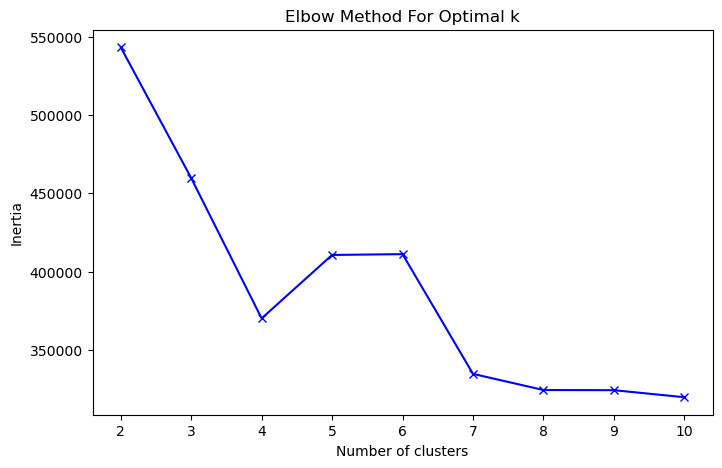

In [58]:
inertia = []
K = range(2, 11)
for k in K:
    inertia.append(calculate_inertia(customer_features_scaled, k))

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

From graph we can see that we are not getting any help in choosing the right value of k(number of clusters). So we will try for different values of k and check the score that defines the quality of clustering.

In [59]:
# Defined function for KMeans with pre-assigned k

def kmeans_clustering(data, k, max_iter=300):
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    for _ in range(max_iter):
        clusters = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
        new_centroids = np.array([data[clusters == i].mean(axis=0) for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return clusters

## For k = 4

In [60]:
k1 = 4
clusters = kmeans_clustering(customer_features_scaled, k1)

# Create a copy of the original dataframe
customer_features_with_clusters = customer_features_combined.copy()

# Add cluster labels to the customer features
customer_features_with_clusters['cluster'] = clusters
customer_features_with_clusters

,order_frequency,total_products,reorder_ratio,aisle_diversity,avg_days_between_orders,avg_order_size,unique_products_ordered,cluster
user_id,,,,,,,,
1,10,59,0.694915,12,20.259259,5.900000,18,0
2,14,195,0.476923,33,15.967033,13.928571,102,2
3,12,88,0.625000,16,11.487179,7.333333,33,0
4,5,18,0.055556,14,15.357143,3.600000,17,1
5,4,37,0.378378,16,14.500000,9.250000,23,1
...,...,...,...,...,...,...,...,...
206205,3,32,0.250000,17,20.666667,10.666667,24,1
206206,67,285,0.473684,50,4.042705,4.253731,150,3
206207,16,223,0.587444,46,14.879397,13.937500,92,2


In [61]:
# Evaluate clusters using Silhouette Score
score = silhouette_score(customer_features_scaled, clusters)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.2412433979261566


In [63]:
cluster_summary = customer_features_with_clusters.groupby('cluster').mean()
cluster_summary

,order_frequency,total_products,reorder_ratio,aisle_diversity,avg_days_between_orders,avg_order_size,unique_products_ordered
cluster,,,,,,,
0,15.636548,91.758896,0.532945,19.288079,11.328436,6.412954,36.947513
1,5.525030,41.774595,0.254433,17.545524,21.637239,7.931083,30.252567
2,14.554613,195.106635,0.462546,40.202628,14.711562,15.206113,95.265922
3,51.708656,623.640757,0.691928,54.145581,7.445021,13.214601,176.889824


### PCA

In [64]:
# Defined function to perform PCA

def pca_manual(data, n_components):
    # Center the data
    data_meaned = data - np.mean(data, axis=0)
    
    # Calculate the covariance matrix
    covariance_matrix = np.cov(data_meaned, rowvar=False)
    
    # Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select a subset from the rearranged Eigenvalue matrix
    eigenvector_subset = sorted_eigenvectors[:, :n_components]
    
    # Transform the data
    transformed_data = -np.dot(data_meaned, eigenvector_subset)
    
    return transformed_data

### Number of componenets = 5

In [66]:
customer_features_pca1 = pca_manual(customer_features_scaled, 5)
customer_features_pca1

array([[ 1.11369793e+00,  1.03055661e+00, -1.35807672e+00,
         3.82190652e-01, -2.97826003e-01],
       [-6.88883206e-01, -6.61583057e-01, -1.53208972e-01,
         2.15777127e-01, -9.53017765e-02],
       [ 4.70895780e-01,  1.14308510e+00, -2.82526078e-01,
         8.21921479e-01, -1.01176199e-01],
       ...,
       [-1.27087451e+00, -5.57410565e-01, -2.81846450e-01,
         3.73397514e-01, -6.36589656e-01],
       [-4.86858633e+00,  4.56873329e-02,  8.89615340e-03,
        -6.19854853e-01, -2.19089258e-03],
       [-1.17305797e-01, -5.06802888e-01, -3.88793310e-01,
        -3.16022248e-01, -7.55205587e-01]])

In [67]:
# Applying k means clustering on the data after reducing the features
clusters_pca1 = kmeans_clustering(customer_features_pca1, k1)

# Add cluster labels to the customer features
customer_features_with_clusters['cluster_pca1'] = clusters_pca1
customer_features_with_clusters

,order_frequency,total_products,reorder_ratio,aisle_diversity,avg_days_between_orders,avg_order_size,unique_products_ordered,cluster,cluster_pca1
user_id,,,,,,,,,
1,10,59,0.694915,12,20.259259,5.900000,18,0,2
2,14,195,0.476923,33,15.967033,13.928571,102,2,3
3,12,88,0.625000,16,11.487179,7.333333,33,0,2
4,5,18,0.055556,14,15.357143,3.600000,17,1,1
5,4,37,0.378378,16,14.500000,9.250000,23,1,1
...,...,...,...,...,...,...,...,...,...
206205,3,32,0.250000,17,20.666667,10.666667,24,1,1
206206,67,285,0.473684,50,4.042705,4.253731,150,3,0
206207,16,223,0.587444,46,14.879397,13.937500,92,2,3


In [68]:
# Evaluate clusters using Silhouette Score
score2 = silhouette_score(customer_features_pca1, clusters_pca1)
print(f'Silhouette Score: {score2}')

Silhouette Score: 0.2478785351009472


### Number of components = 2

In [69]:
customer_features_pca2 = pca_manual(customer_features_scaled, 2)
customer_features_pca2

array([[ 1.11369793,  1.03055661],
       [-0.68888321, -0.66158306],
       [ 0.47089578,  1.1430851 ],
       ...,
       [-1.27087451, -0.55741057],
       [-4.86858633,  0.04568733],
       [-0.1173058 , -0.50680289]])

In [70]:
# Applying k means clustering on the data after reducing the features
clusters_pca2 = kmeans_clustering(customer_features_pca2, k1)

# Add cluster labels to the customer features
customer_features_with_clusters['cluster_pca2'] = clusters_pca2
customer_features_with_clusters

,order_frequency,total_products,reorder_ratio,aisle_diversity,avg_days_between_orders,avg_order_size,unique_products_ordered,cluster,cluster_pca1,cluster_pca2
user_id,,,,,,,,,,
1,10,59,0.694915,12,20.259259,5.900000,18,0,2,3
2,14,195,0.476923,33,15.967033,13.928571,102,2,3,2
3,12,88,0.625000,16,11.487179,7.333333,33,0,2,0
4,5,18,0.055556,14,15.357143,3.600000,17,1,1,3
5,4,37,0.378378,16,14.500000,9.250000,23,1,1,3
...,...,...,...,...,...,...,...,...,...,...
206205,3,32,0.250000,17,20.666667,10.666667,24,1,1,3
206206,67,285,0.473684,50,4.042705,4.253731,150,3,0,1
206207,16,223,0.587444,46,14.879397,13.937500,92,2,3,2


In [71]:
# Evaluate clusters using Silhouette Score
score3 = silhouette_score(customer_features_pca2, clusters_pca2)
print(f'Silhouette Score: {score3}')

Silhouette Score: 0.366498914733215


Here, we can see that we are getting more score when the number of features are reduced using PCA.

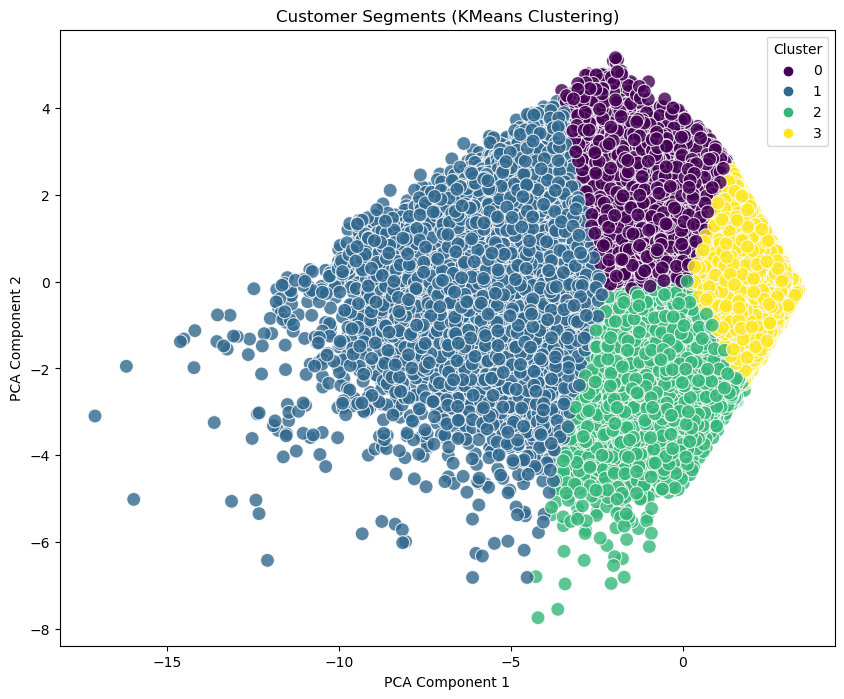

In [72]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=customer_features_pca2[:, 0], y=customer_features_pca2[:, 1], hue=clusters_pca2, palette='viridis', s=100, alpha=0.8)
plt.title('Customer Segments (KMeans Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

## K = 5

We have seen that on reducing the number of features, score is increasing. So, I decided to work with "customer_features_pca2".

In [75]:
k2 = 5
clusters_5 = kmeans_clustering(customer_features_pca2, k2)

# Create a copy of the original dataframe
customer_features_with_clusters2 = customer_features_combined.copy()

# Add cluster labels to the customer features
customer_features_with_clusters2['cluster'] = clusters_5
customer_features_with_clusters2

,order_frequency,total_products,reorder_ratio,aisle_diversity,avg_days_between_orders,avg_order_size,unique_products_ordered,cluster
user_id,,,,,,,,
1,10,59,0.694915,12,20.259259,5.900000,18,4
2,14,195,0.476923,33,15.967033,13.928571,102,2
3,12,88,0.625000,16,11.487179,7.333333,33,4
4,5,18,0.055556,14,15.357143,3.600000,17,3
5,4,37,0.378378,16,14.500000,9.250000,23,3
...,...,...,...,...,...,...,...,...
206205,3,32,0.250000,17,20.666667,10.666667,24,3
206206,67,285,0.473684,50,4.042705,4.253731,150,0
206207,16,223,0.587444,46,14.879397,13.937500,92,0


In [76]:
# Evaluate clusters using Silhouette Score
score4 = silhouette_score(customer_features_pca2, clusters_5)
print(f'Silhouette Score: {score4}')

Silhouette Score: 0.3346057645461668


## K = 6

In [77]:
k3 = 6
clusters_6 = kmeans_clustering(customer_features_pca2, k3)

# Create a copy of the original dataframe
customer_features_with_clusters3 = customer_features_combined.copy()

# Add cluster labels to the customer features
customer_features_with_clusters3['cluster'] = clusters_6
customer_features_with_clusters3

,order_frequency,total_products,reorder_ratio,aisle_diversity,avg_days_between_orders,avg_order_size,unique_products_ordered,cluster
user_id,,,,,,,,
1,10,59,0.694915,12,20.259259,5.900000,18,5
2,14,195,0.476923,33,15.967033,13.928571,102,1
3,12,88,0.625000,16,11.487179,7.333333,33,5
4,5,18,0.055556,14,15.357143,3.600000,17,2
5,4,37,0.378378,16,14.500000,9.250000,23,2
...,...,...,...,...,...,...,...,...
206205,3,32,0.250000,17,20.666667,10.666667,24,2
206206,67,285,0.473684,50,4.042705,4.253731,150,4
206207,16,223,0.587444,46,14.879397,13.937500,92,0


In [78]:
# Evaluate clusters using Silhouette Score
score5 = silhouette_score(customer_features_pca2, clusters_6)
print(f'Silhouette Score: {score5}')

Silhouette Score: 0.3272629168921766


We can see that as we are taking more number of clusters we are getting bad results, so I decided to stop here. I will try one taking less number of clusters.

## K = 3

In [79]:
k4 = 3
clusters_3 = kmeans_clustering(customer_features_pca2, k4)

# Create a copy of the original dataframe
customer_features_with_clusters4 = customer_features_combined.copy()

# Add cluster labels to the customer features
customer_features_with_clusters4['cluster'] = clusters_3
customer_features_with_clusters4

,order_frequency,total_products,reorder_ratio,aisle_diversity,avg_days_between_orders,avg_order_size,unique_products_ordered,cluster
user_id,,,,,,,,
1,10,59,0.694915,12,20.259259,5.900000,18,1
2,14,195,0.476923,33,15.967033,13.928571,102,0
3,12,88,0.625000,16,11.487179,7.333333,33,1
4,5,18,0.055556,14,15.357143,3.600000,17,1
5,4,37,0.378378,16,14.500000,9.250000,23,1
...,...,...,...,...,...,...,...,...
206205,3,32,0.250000,17,20.666667,10.666667,24,1
206206,67,285,0.473684,50,4.042705,4.253731,150,2
206207,16,223,0.587444,46,14.879397,13.937500,92,0


In [80]:
# Evaluate clusters using Silhouette Score
score6 = silhouette_score(customer_features_pca2, clusters_3)
print(f'Silhouette Score: {score6}')

Silhouette Score: 0.36821574521780503


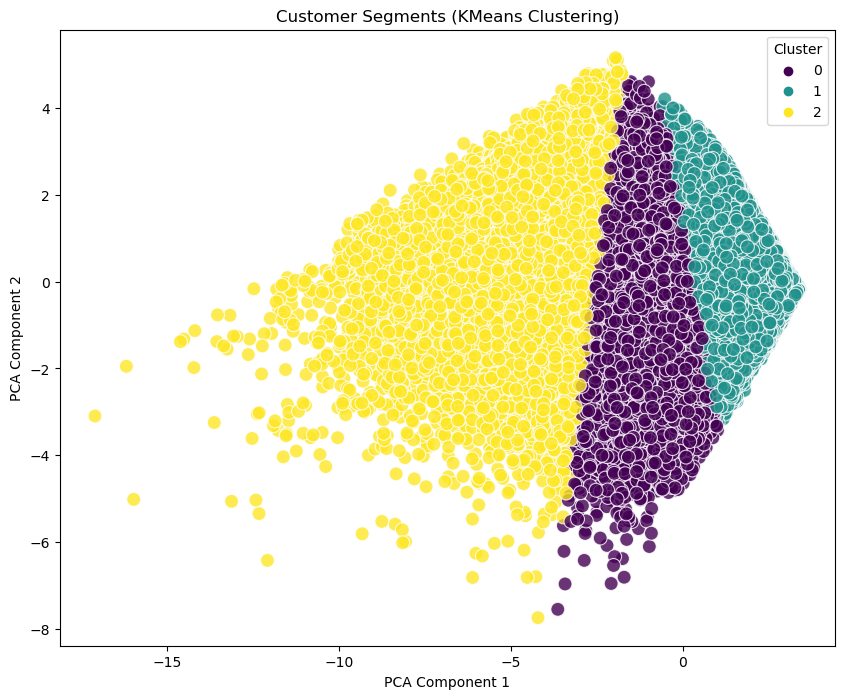

In [84]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=customer_features_pca2[:, 0], y=customer_features_pca2[:, 1], hue=clusters_3, palette='viridis', s=100, alpha=0.8)
plt.title('Customer Segments (KMeans Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

## Result:

Here we can see that in the above case we are getting slightly better result than the case of k = 4(with reduced fatures to 2). So we will use these two cases to make inference about customer behaviour.

### Case1: K = 4

In [82]:
columns_to_drop = ['cluster', 'cluster_pca1']

customer_features_with_clusters = customer_features_with_clusters.drop(columns=columns_to_drop)
cluster_summary1 = customer_features_with_clusters.groupby('cluster_pca2').mean()
cluster_summary1

,order_frequency,total_products,reorder_ratio,aisle_diversity,avg_days_between_orders,avg_order_size,unique_products_ordered
cluster_pca2,,,,,,,
0,24.869858,174.885156,0.613484,28.542381,10.177466,7.527958,63.353481
1,48.285177,623.239946,0.678943,55.822615,7.985464,14.364811,182.016883
2,10.303168,153.645845,0.394718,37.565351,17.186073,16.070994,85.208184
3,6.252132,40.094021,0.309935,15.800892,18.793824,6.903354,26.607632


### Inference:

Cluster 0: Balanced and consistent consumers with moderate activity.

Cluster 1: Highly active and engaged consumers with frequent, diverse purchases.

Cluster 2: Infrequent but large orders with moderate to high product diversity.

Cluster 3: Minimal engagement with infrequent, small, and less diverse purchases.

### Case2: K = 3

In [83]:
cluster_summary2 = customer_features_with_clusters4.groupby('cluster').mean()
cluster_summary2

,order_frequency,total_products,reorder_ratio,aisle_diversity,avg_days_between_orders,avg_order_size,unique_products_ordered
cluster,,,,,,,
0,17.323864,183.251339,0.496851,36.694056,13.695883,12.990685,84.684835
1,7.348447,46.074466,0.338044,16.633539,18.203623,7.227193,28.598039
2,49.906221,612.519691,0.688199,54.231617,7.734266,13.790958,175.859116


### Inference:

Cluster 0: Balanced consumers with moderate order frequency, product diversity, and order sizes.

Cluster 1: Less active consumers with infrequent, small orders, low product diversity, and minimal engagement.

Cluster 2: Highly active consumers with frequent orders, high product diversity, and significant engagement.